# Test SNIa Lightcurve Fits

Play around with the `sncosmo` fitter a bit more to see how the input boundaries on redshift affect the outputs.

There are a couple of **TO DO** remarks in Section 2.

## 0. Set up

Before you open this notebook (or close and shutdown nb and reopen if it's already open),
some software needs to be installed.

In a terminal:
    
`module load python`

and then 

`pip install sncosmo`

and 

`pip install iminuit`

The following cell also needs to be uncommented and executed once
(or remove the # and % and execute this from the command line).
Use of the following was found 
<a href="https://stackoverflow.com/questions/67117848/a-question-about-modulenotfounderror-no-module-named-numpy-typing">here in Stack Overflow </a>
and it has to do with the version of `numpy`.

In [1]:
# %pip install -U numpy

There are still a couple of warnings during import, but they don't seem to hurt anything.

In [2]:
import sncosmo
import iminuit
import numpy as np

/global/common/software/nersc/cori-2022q1/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Check numpy version.

In [3]:
np.__version__

'1.24.2'

## 1. Test `sncosmo`

Use their example of how to test. 

https://sncosmo.readthedocs.io/en/stable/examples/plot_lc_fit.html#sphx-glr-examples-plot-lc-fit-py


In [4]:
data = sncosmo.load_example_data()
print(data)

     time      band       flux         fluxerr      zp  zpsys
------------- ----- --------------- -------------- ---- -----
      55070.0 sdssg   0.36351153597 0.672843847541 25.0    ab
55072.0512821 sdssr -0.200801295864 0.672843847541 25.0    ab
55074.1025641 sdssi  0.307494232981 0.672843847541 25.0    ab
55076.1538462 sdssz   1.08776103656 0.672843847541 25.0    ab
55078.2051282 sdssg  -0.43667895645 0.672843847541 25.0    ab
55080.2564103 sdssr   1.09780966779 0.672843847541 25.0    ab
55082.3076923 sdssi    3.7562685627 0.672843847541 25.0    ab
55084.3589744 sdssz   5.34858894966 0.672843847541 25.0    ab
55086.4102564 sdssg   2.82614187269 0.672843847541 25.0    ab
55088.4615385 sdssr   7.56547045054 0.672843847541 25.0    ab
          ...   ...             ...            ...  ...   ...
55129.4871795 sdssr    2.6597485586 0.672843847541 25.0    ab
55131.5384615 sdssi   3.99520404021 0.672843847541 25.0    ab
55133.5897436 sdssz   5.73989458094 0.672843847541 25.0    ab
55135.64

Create a model.

In [5]:
model = sncosmo.Model(source='salt2')

Run the fit.

In [6]:
result, fitted_model = sncosmo.fit_lc(
    data, model,
    ['z', 't0', 'x0', 'x1', 'c'],  # parameters of model to vary
    bounds={'z':(0.3, 0.7)})       # bounds on parameters (if any)

Print some of the fit results.

In [7]:
print("Number of chi^2 function calls:", result.ncall)
print("Number of degrees of freedom in fit:", result.ndof)
print("chi^2 value at minimum:", result.chisq)
print("model parameters:", result.param_names)
print("best-fit values:", result.parameters)
print("The result contains the following attributes:\n", result.keys())

Number of chi^2 function calls: 133
Number of degrees of freedom in fit: 35
chi^2 value at minimum: 33.80988236076295
model parameters: ['z', 't0', 'x0', 'x1', 'c']
best-fit values: [5.15154859e-01 5.51004778e+04 1.19625368e-05 4.67270999e-01
 1.93951997e-01]
The result contains the following attributes:
 dict_keys(['success', 'message', 'ncall', 'chisq', 'ndof', 'param_names', 'parameters', 'vparam_names', 'covariance', 'errors', 'nfit', 'data_mask'])


Show the fitted light curve to the data.

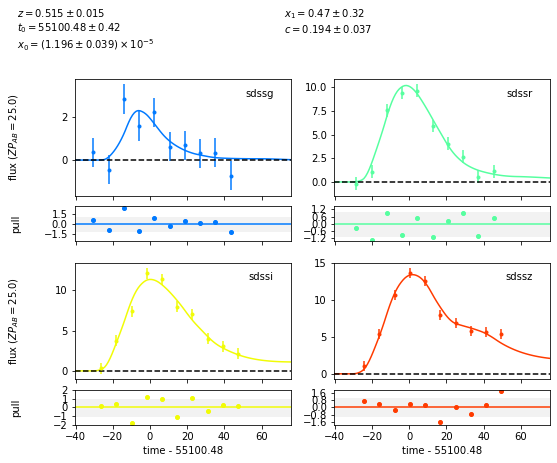

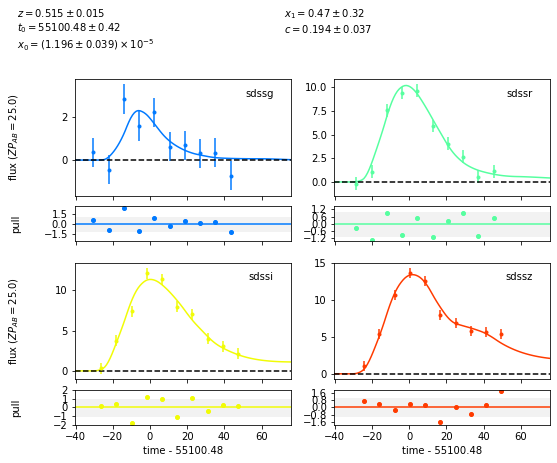

In [8]:
sncosmo.plot_lc(data, model=fitted_model, errors=result.errors)

## 2. Test `sncosmo` with just one DDF potential SNIa

Load the nightly epoch lightcurves for candidates.

In [9]:
path = '../extragalactic_fields/candidate_nightly_epochs_files/'
fnm = path + 'candidate_lightcurves.dat'
candLC_field   = np.loadtxt(fnm, dtype='str', usecols=(0))
candLC_candid  = np.loadtxt(fnm, dtype='str', usecols=(1))
candLC_caldate = np.loadtxt(fnm, dtype='str', usecols=(2))
candLC_mjd     = np.loadtxt(fnm, dtype='float', usecols=(3))
candLC_filter  = np.loadtxt(fnm, dtype='str', usecols=(4))
candLC_Nobj    = np.loadtxt(fnm, dtype='int', usecols=(5))
candLC_mag     = np.loadtxt(fnm, dtype='float', usecols=(6))
candLC_mage    = np.loadtxt(fnm, dtype='float', usecols=(7))
candLC_mrb     = np.loadtxt(fnm, dtype='float', usecols=(8))
candLC_maglim  = np.loadtxt(fnm, dtype='float', usecols=(9))
del fnm

Define the candidate id to use.

In [10]:
my_potential_snia = 'DC21dhgr'

Find all elements of the `candLC` array associated with this candidate.

In [11]:
tx = np.where(candLC_candid == my_potential_snia)[0]

How many nightly epochs (data points) are associated with this candidate.

In [12]:
print(len(tx))

135


Write the LC to a file that is formatted in a way that `sncosmo` can read.

In [13]:
fout = open('test.txt', 'w')
fout.write('     time      band       flux         fluxerr      zp  zpsys \n')
# fout.write('------------- ----- --------------- -------------- ---- ----- \n')
for x in tx:
    if np.isfinite(candLC_mag[x]):
        flux = 10.0**((candLC_mag[x] - 25.0)/(-2.5))
        fluxhi = 10.0**(((candLC_mag[x]-candLC_mage[x]) - 25.0)/(-2.5))
        fluxe = fluxhi - flux
        fout.write('%13.4f %5s %15.7f %14.7f  25.  ab \n' % \
                   (candLC_mjd[x], 'sdss'+candLC_filter[x], flux, fluxe))
fout.close()

Read the LC with `sncosmo`.

In [14]:
data2 = sncosmo.read_lc('test.txt')

### 2.1. Do the fit using the `sncosmo` demo inputs.

Do the fit exactly like as above.

In [15]:
result2, fitted_model2 = sncosmo.fit_lc(
    data2, model,
    ['z', 't0', 'x0', 'x1', 'c'],  # parameters of model to vary
    bounds={'z':(0.3, 0.7)})       # bounds on parameters (if any)

Show the results as a plot.

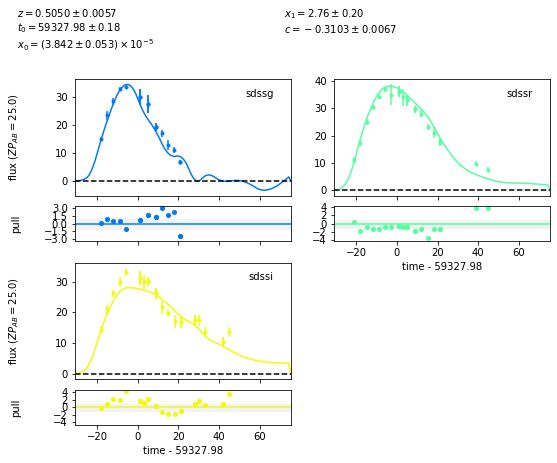

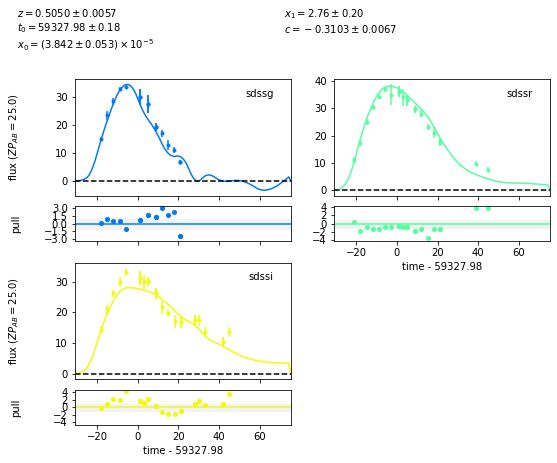

In [16]:
sncosmo.plot_lc(data2, model=fitted_model2, errors=result2.errors)

Figure out how to get the fit parameters and errors from the outputs.

In [17]:
fitted_model2.param_names

['z', 't0', 'x0', 'x1', 'c']

In [18]:
result2['param_names']

['z', 't0', 'x0', 'x1', 'c']

In [19]:
fitted_model2.parameters

array([ 5.04961264e-01,  5.93279814e+04,  3.84171148e-05,  2.75918156e+00,
       -3.10295772e-01])

In [20]:
result2['parameters']

array([ 5.04961264e-01,  5.93279814e+04,  3.84171148e-05,  2.75918156e+00,
       -3.10295772e-01])

In [21]:
result2['errors']

OrderedDict([('z', 0.005740285832856323),
             ('t0', 0.17626147854389274),
             ('x0', 5.303479860621162e-07),
             ('x1', 0.19507218176885283),
             ('c', 0.006661157607836626)])

In [22]:
param1 = result2['parameters']
error1 = result2['errors']

### 2.2. Play around to learn more

What happens if we change the boundaries on redshift to 0.1 to 1.0?

In [23]:
result2, fitted_model2 = sncosmo.fit_lc(
    data2, model,
    ['z', 't0', 'x0', 'x1', 'c'],  # parameters of model to vary
    bounds={'z':(0.1, 1.0)})       # bounds on parameters (if any)

/global/homes/m/midorr/.local/cori/3.9-anaconda-2021.11/lib/python3.9/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: sdssg(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +


Ah! A good lesson. The error above tells me it dropped the g-band, and didn't try to fit it.

I think this is because observer-frame g-band (4500 Angstroms) is, at a redshift of z=1.0, rest-frame 2250 Angstroms, which is "far-UV" and yeah, we don't have model SNIa lightcurves at those wavelengths.

Execute the cell below and you will see that indeed, the g-band is very poorly fit.

> **TO DO:** As for the x0, x1, and c values, I'm not sure if they're "odd" for a SNIa? As in, if we didn't look at the plot, would we know from the values and the errors that this failed to get a good fit? 

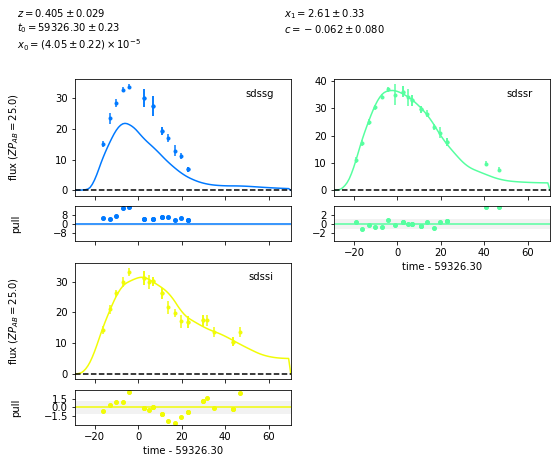

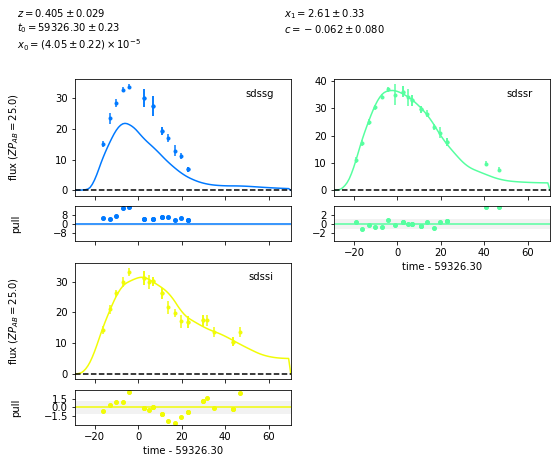

In [24]:
sncosmo.plot_lc(data2, model=fitted_model2, errors=result2.errors)

In [25]:
param2 = result2['parameters']
error2 = result2['errors']

### 2.3. What kind of bounds should we put on redshift?

SNIa are standard candles, meaning their peak brightness is correlated with their redshift (this is the Hubble Diagram, basically).

If we know the absolute magnitude of SNIa is about $M = -19$,
then we can get the approximate distance modulus $\mu$ with $\mu = m - M$.

Once we have $\mu$, we can get the luminosity distance in Mpc, $D_L$, with $\mu = 5log(D_L) + 25$.

Once we have $D_L$, we can use the Hubble Relation assuming $H_0 = 70$ km/s/Mpc, using $z_{km/s} = H_0 * D_L$.

Once we have redshift in km/s, we make it unitless by dividing by the speed of light, $ z = z_{km/s}/c$, where $c=500000$ km/s.

For example, a SNIa with a peak brightness of 22 mag is at a redshift of about $z = 0.2$.

And a SNIa with a peak brightness of 24 mag, about the limit of our DDF, is at about $z = 0.6$.

So!

We can use the lightcurve itself to put initial boundaries on redshift and help the fitter out.

First, remind ourselves of the contents of the data array.

In [26]:
z=(70*(10**(((24-(-19))-25)/5)))/500000
z

0.5573500387748963

In [27]:
data2

time,band,flux,fluxerr,zp,zpsys
float64,str5,float64,float64,float64,str2
59307.0609,sdssr,11.137815,1.052081,25.0,ab
59310.0668,sdssg,15.0383435,0.8398102,25.0,ab
59310.0678,sdssr,17.1711744,1.1266729,25.0,ab
59310.0692,sdssi,14.2298394,1.3011813,25.0,ab
59313.0594,sdssg,23.3991456,1.696594,25.0,ab
59313.0604,sdssr,25.0957396,1.1343636,25.0,ab
59313.0618,sdssi,20.9700758,1.4171356,25.0,ab
59316.0452,sdssg,28.4446111,1.2857374,25.0,ab
59316.0463,sdssr,30.4228573,0.91,25.0,ab


Get the minimum observed magnitude. It's not necessarily the peak, but, if our data does not cover the true peak of the SN's lightcurve, the fit is going to be bad anyway.

In [28]:
fluxarr = np.asarray(data2['flux'], dtype='float')
zparr = np.asarray(data2['zp'], dtype='float')
magarr = -2.5 * np.log10(fluxarr) + zparr
min_magarr = np.min(magarr)
print('Brightest observed magnitude: %5.2f' % min_magarr)

Brightest observed magnitude: 21.08


In [29]:
estimated_redshift = 70.0 * 10.0**(((min_magarr + 19.3) - 25.0)/5.0) / 500000.0
print('estimated_redshift = %5.3f ' % estimated_redshift)

estimated_redshift = 0.167 


Alright, let's give it a fairly broad range around there. 

Above, we didn't mention other factors, like how -19.3 is the rest-frame B-band brightness,
which make our estimated redshift VERY much an ESTIMATE with finger quotes.

What we can be sure of is that, if this is a SNIa, it's not like, z>0.4 with that peak brightness.

A range of $\pm 0.1$ to $0.15$ is appropriate here, so try:

In [39]:
result2, fitted_model2 = sncosmo.fit_lc(
    data2, model,
    ['z', 't0', 'x0', 'x1', 'c'],  # parameters of model to vary
    bounds={'z':(0.05, 0.3),'x1':(-3,3),'c':(-0.3,0.3)})       # bounds on parameters (if any)

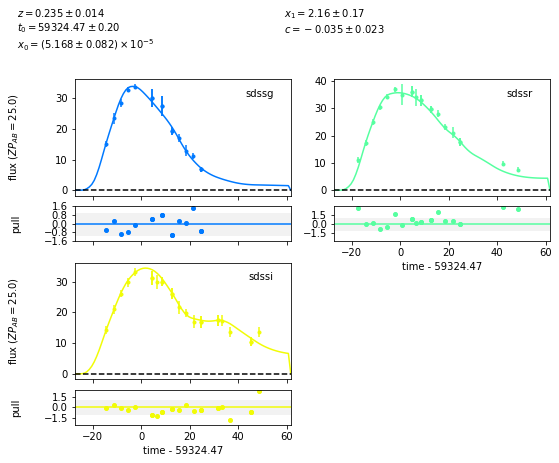

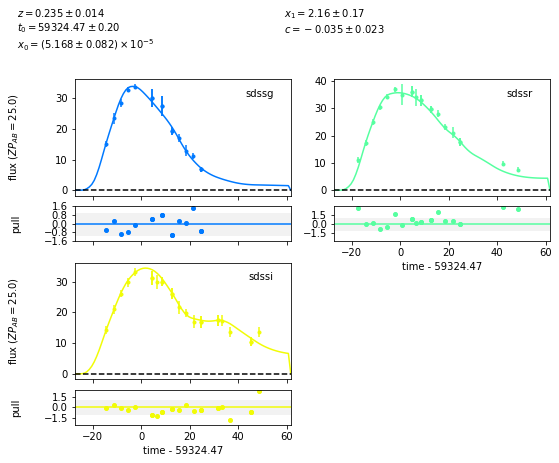

In [40]:
sncosmo.plot_lc(data2, model=fitted_model2, errors=result2.errors)

In [32]:
param3 = result2['parameters']
error3 = result2['errors']

Hey that fit looks much better! 

> **TO DO:** Compare the fit parameters and their errors from the three different fits; can we tell this last one is the best just from the values and errors? 

#### Parameters + errors of first fit

In [33]:
print(param1)
print(error1)

[ 5.04961264e-01  5.93279814e+04  3.84171148e-05  2.75918156e+00
 -3.10295772e-01]
OrderedDict([('z', 0.005740285832856323), ('t0', 0.17626147854389274), ('x0', 5.303479860621162e-07), ('x1', 0.19507218176885283), ('c', 0.006661157607836626)])


#### Parameters + errors of second fit

In [34]:
print(param2)
print(error2)

[ 4.05064406e-01  5.93263044e+04  4.05229460e-05  2.60646204e+00
 -6.22182698e-02]
OrderedDict([('z', 0.02904904120787269), ('t0', 0.22552874516986776), ('x0', 2.2454599001495027e-06), ('x1', 0.32760202031937286), ('c', 0.0799086006792723)])


#### Parameters + errors of third fit

In [35]:
print(param3)
print(error3)

[ 2.35338607e-01  5.93244727e+04  5.16787299e-05  2.15989920e+00
 -3.53557791e-02]
OrderedDict([('z', 0.013724086348658418), ('t0', 0.19521322498985683), ('x0', 8.102747799251435e-07), ('x1', 0.1681692730832608), ('c', 0.0223255905776152)])


Among the 3 fits, the third fit has the smallest errors in x0 and x1, but second smallest error in c. The third fit also has largest x0, smallest x1, and smallest c.

Need to find "normal" range of values.

In [38]:
fitted_model.description

'salt2'

In [ ]:
**UPDATE**

We don't always capture the peak brightness of the SNe (e.g. just the decline), which will thus underestimate the peak and affect the estimated redshift. Taking this into consideration, e will no longer be estimating the likely redshift range for each candidate using their peak brightnesses, but rather using a fixed range, z = 0.02 to z = 0.5.